<a href="https://colab.research.google.com/github/kushagra-2503/Recursive-Neural-Network/blob/master/fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
uploaded = files.upload()


Saving val2.tsv to val2.tsv
Saving train2.tsv to train2.tsv
Saving test2.tsv to test2.tsv


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import bisect
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [0]:
from nltk.stem.porter import PorterStemmer
import nltk 
import string

In [0]:
trans_table = {ord(c): None for c in string.punctuation + string.digits}    
stemmer = PorterStemmer()

def tokenize(text):
        # my text was unicode so I had to use the unicode-specific translate function. If your documents are strings, you will need to use a different `translate` function here. `Translated` here just does search-replace. See the trans_table: any matching character in the set is replaced with `None`
        tokens = [word for word in nltk.word_tokenize(text.translate(trans_table)) if len(word) > 1] #if len(word) > 1 because I only want to retain words that are at least two characters before stemming, although I can't think of any such words that are not also stopwords
        stems = [stemmer.stem(item) for item in tokens]
        return stems


In [0]:
train_data = pd.read_csv('train2.tsv', delimiter = '\t', header = None)
val_data = pd.read_csv('val2.tsv', delimiter = '\t', header = None)
test_data = pd.read_csv('test2.tsv', delimiter = '\t', header = None)
train_data = train_data.iloc[:, 2:]
val_data = val_data.iloc[:, 2:]
test_data= test_data.iloc[:, 2:]

In [96]:
train_data.head()

,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [0]:
val_data.head()

In [0]:
features=['statement','subject','speaker','job-title','state info','affliation','barely true','false','half true','mostly true','pants on fire','context', 'justification']

In [0]:
X_train.columns = features
X_val.columns = features
X_test.columns = features

In [0]:
statements = X_train.iloc[:, 0]
justifications = X_train.loc[:,'justification']
statements_val = X_val.iloc[:, 0]
justifications_val = X_train.loc[:, 'justification']
statements_test = X_test.iloc[:, 0]
justifications_test = X_test.loc[:, 'justification']

In [104]:
statements.values

array(['Says the Annies List political group supports third-trimester abortions on demand.',
       'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.',
       'Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."',
       ...,
       'Says an alternative to Social Security that operates in Galveston County, Texas, has meant that participants will retire with a whole lot more money than under Social Security.',
       'On lifting the U.S. Cuban embargo and allowing travel to Cuba.',
       "The Department of Veterans Affairs has a manual out there telling our veterans stuff like, 'Are you really of value to your community?' You know, encouraging them to commit suicide."],
      dtype=object)

# **Binary Classification**

In [0]:
def map_labels():
  for i, rows in train_data.iterrows():
      if((train_data.iloc[i,0] == "half-true") | (train_data.iloc[i,0] == "mostly-true") | (train_data.iloc[i,0] == "true")):
          train_data.iloc[i,0] = "true"
      else:
         train_data.iloc[i, 0] = "false"
        
  for i, rows in val_data.iterrows():
      if((val_data.iloc[i,0] == "half-true") | (val_data.iloc[i,0] == "mostly-true") | (val_data.iloc[i,0] == "true")):
          val_data.iloc[i,0] = "true"
      else:
          val_data.iloc[i, 0] = "false"
        
  for i, rows in test_data.iterrows():
      if((test_data.iloc[i,0] == "half-true") | (test_data.iloc[i,0] == "mostly-true") | (test_data.iloc[i,0] == "true")):
          test_data.iloc[i,0] = "true"
      else:
          test_data.iloc[i, 0] = "false" 

In [0]:
map_labels()

In [0]:
X_train = train_data.iloc[:,1:]
Y_train = train_data.iloc[:,0]
X_val = val_data.iloc[:, 1:]
Y_val = val_data.iloc[:, 0]
X_test = test_data.iloc[:, 1:]
Y_test = test_data.iloc[:, 0]

In [109]:
train_data.head()

,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [0]:
#val_data.head()

In [111]:
count_vectorizer = CountVectorizer(ngram_range = (1,3),stop_words = 'english', max_df = 0.7)
count_train = count_vectorizer.fit_transform(statements.values)
count_val = count_vectorizer.transform(statements_val.values)
count_train

<10240x160505 sparse matrix of type '<class 'numpy.int64'>'
	with 281368 stored elements in Compressed Sparse Row format>

In [0]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_df = 0.7)
tfidf_train = tfidf_vectorizer.fit_transform(statements.values)
tfidf_val = tfidf_vectorizer.transform(statements_val.values)

In [0]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

0.6093133385951065
Confusion matrix, without normalization
0.5758251479656123


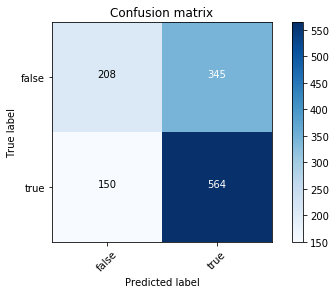

In [114]:
nb_pipeline = Pipeline([('NBCV', CountVectorizer(stop_words='english',ngram_range=(1,3))), ('nb_clf', MultinomialNB())])
nb_pipeline.fit(statements.values, Y_train)
predicted_nb = nb_pipeline.predict(statements_test.values)
print(np.mean(predicted_nb == Y_test))
cm = metrics.confusion_matrix(Y_test, predicted_nb, labels = ['false', 'true'])
plot_confusion_matrix(cm, classes = ['false', 'true'])
print(metrics.f1_score(list(Y_test), predicted_nb, average = 'macro'))

0.6132596685082873
Confusion matrix, without normalization
0.5992369861598843


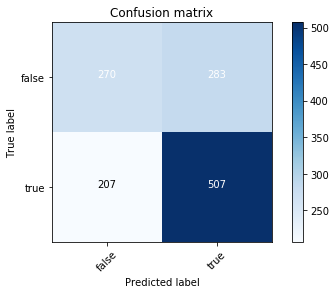

In [115]:
sgd_pipeline = Pipeline([('SGDV', CountVectorizer(stop_words='english',ngram_range=(1,4))),('sgd_clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3))])
sgd_pipeline.fit(statements.values, Y_train)
predicted_sgd = sgd_pipeline.predict(statements_test.values)
print(np.mean(predicted_sgd == Y_test))
cm = metrics.confusion_matrix(Y_test, predicted_sgd, labels = ['false', 'true'])
plot_confusion_matrix(cm, classes = ['false', 'true'])
print(metrics.f1_score(list(Y_test), predicted_sgd, average = 'macro'))

0.6156274664561957
Confusion matrix, without normalization
0.6032256176882322


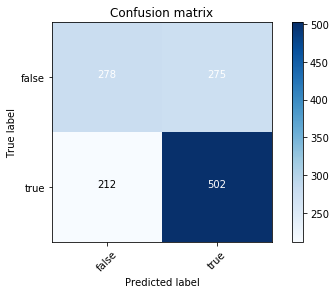

In [116]:
svm_pipeline = Pipeline([('SVMV', CountVectorizer(ngram_range = (1,3), stop_words = 'english')), ('svm_clf', svm.LinearSVC())])
svm_pipeline.fit(statements.values, Y_train)
pred_svc = svm_pipeline.predict(statements_test.values)
print(np.mean(pred_svc == Y_test))
cm = metrics.confusion_matrix(Y_test, pred_svc, labels = ['false', 'true'])
plot_confusion_matrix(cm, classes = ['false', 'true'])
print(metrics.f1_score(list(Y_test), pred_svc, average = 'macro'))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5927387529597474
Confusion matrix, without normalization


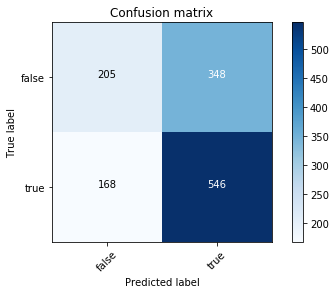

In [117]:
rf_pipeline = Pipeline([('RFCV', CountVectorizer(ngram_range = (1,3), stop_words = 'english')), ('rf_clf', RandomForestClassifier())])
rf_pipeline.fit(statements.values, Y_train)
pred_rf = rf_pipeline.predict(statements_test.values)
print(np.mean(pred_rf == Y_test))
cm = metrics.confusion_matrix(Y_test, pred_rf, labels = ['false', 'true'])
plot_confusion_matrix(cm, classes = ['false', 'true'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6164167324388319
Confusion matrix, without normalization
0.6032256176882322


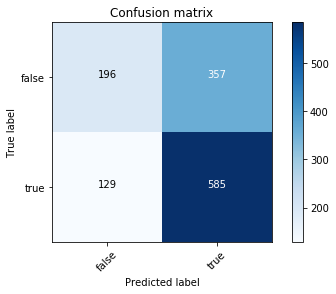

In [135]:
logR_pipeline = Pipeline([
        ('LogR_tfidf',TfidfVectorizer(analyzer = 'word', tokenizer = tokenize, stop_words='english',ngram_range=(1,5),use_idf=True,smooth_idf=True)),
        ('LogR_clf',LogisticRegression(penalty="l2",C=1))
        ])
logR_pipeline_final.fit(statements.values,Y_train)
pred_logR = logR_pipeline_final.predict(statements_test.values)
print(np.mean(pred_logR == Y_test))
cm = metrics.confusion_matrix(Y_test, pred_logR, labels = ['false', 'true'])
plot_confusion_matrix(cm, classes = ['false', 'true'])
print(metrics.f1_score(list(Y_test), pred_svc, average = 'macro'))

# **Multi Class Classification**

In [0]:
le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_test = le.transform(Y_test)

In [77]:
nb_pipeline = Pipeline([('NBCV', CountVectorizer(stop_words='english',ngram_range=(1,3))), ('nb_clf', MultinomialNB())])
nb_pipeline.fit(statements.values, Y_train)
predicted_nb = nb_pipeline.predict(statements_test.values)
print(np.mean(predicted_nb == Y_test))

0.24704025256511444


In [78]:
sgd_pipeline = Pipeline([('SGDV', CountVectorizer(stop_words='english',ngram_range=(1,4))),('sgd_clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3))])
sgd_pipeline.fit(statements.values, Y_train)
predicted_sgd = sgd_pipeline.predict(statements_test.values)
print(np.mean(predicted_sgd == Y_test))

0.24546172059984214


In [79]:
svm_pipeline = Pipeline([('SVMV', CountVectorizer(ngram_range = (1,3), stop_words = 'english')), ('svm_clf', svm.LinearSVC())])
svm_pipeline.fit(statements.values, Y_train)
pred_svc = svm_pipeline.predict(statements_test.values)
print(np.mean(pred_svc == Y_test))

0.2541436464088398


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [80]:
rf_pipeline = Pipeline([('RFCV', CountVectorizer(ngram_range = (1,3), stop_words = 'english')), ('rf_clf', RandomForestClassifier())])
rf_pipeline.fit(statements.values, Y_train)
pred_rf = rf_pipeline.predict(statements_test.values)
print(np.mean(pred_rf == Y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.21783741120757696


In [81]:
logR_pipeline = Pipeline([
        ('LogR_tfidf',TfidfVectorizer(stop_words='english',ngram_range=(1,5),use_idf=True,smooth_idf=False)),
        ('LogR_clf',LogisticRegression(penalty="l2",C=1))
        ])
logR_pipeline_final.fit(statements.values,Y_train)
pred_logR = logR_pipeline_final.predict(statements_test.values)
print(np.mean(pred_logR == Y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.23914759273875297


In [0]:
cvec = CountVectorizer(stop_words = 'english').fit(X_train['statement'].values)
df_statement_train = pd.DataFrame(cvec.transform(X_train['statement'].values).todense(), columns = cvec.get_feature_names())
df_statement_test = pd.DataFrame(cvec.transform(X_test['statement'].values).todense(), columns = cvec.get_feature_names())

In [0]:
X_train['justification'] = X_train.justification.fillna('')
X_test['justification'] = X_test.justification.fillna('')

In [0]:
cvec = CountVectorizer(stop_words = 'english').fit(X_train['justification'].values)
df_justification_train = pd.DataFrame(cvec.transform(X_train['justification'].values).todense(), columns = cvec.get_feature_names())
df_justification_test = pd.DataFrame(cvec.transform(X_test['justification'].values).todense(), columns = cvec.get_feature_names())

In [0]:
train = pd.concat([df_statement_train, df_justification_train], axis =1)
test = pd.concat([df_statement_test, df_justification_test], axis =1)

In [0]:
lr1 = LogisticRegression()

In [87]:
lr1.fit(train, Y_train)
lr1.score(test, Y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.2217837411207577

In [88]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(train, Y_train)
rf_classifier.score(test, Y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.22336227308603

In [89]:
sgd_classifier = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 1e-3)
sgd_classifier.fit(train, Y_train)
sgd_classifier.score(test, Y_test)

0.2067876874506709